<h1> Analysis of the Bimetallic Database for Catalysis </h1>

<h2> Introduction </h2>

As global demand for energy increases dramatically over the coming decades, one of the most important problems we face is the need to reduce harmful greenhouse gas and particulate emissions.  Discovering new clean, alternative energy solutions that can economically compete with fossil fuels is critical to realizing this change. Hydrogen fuel cells are a promising alternative energy storage and delivery technology.   One issue which prohibits the wide use of fuel cells is the need for expensive Pt catalysts.  According to one study, Pt catalysts are responsible for 56% of the cost of a typical fuel cell stack.  Due to increasing computational resources, as well as improved algorithms for density functional theory (DFT), one emerging area in material design is the use of high-throughput computing to design and discover materials. When searching for catalytic materials, researchers explore the mechanisms of chemical reactions of interest and identify quantities (e.g., binding energies), that can be used as a simple way of predicting catalytic ability.  For example, the binding energy of oxygen is commonly used to predict the catalytic ability for the Oxygen Reduction Reaction (ORR) as can be seen in Figure 1.    

![](img/volcano_plot2.png)
<center> <b>Figure 1.</b> Relationship between oxygen binding energies (x-axis) and catalytic activity (y-axis).  <br>This figure is a modified version from https://doi.org/10.1021/jp047349j  </center>
<br><br>
In my current work, we are using high-throughput computing to explore random bimetallic alloys as potential catalysts for the ORR and hydrogen evolution reaction (HER) – both relevant for hydrogen fuel cells. Random bimetallic are unique in that the surface geometry contains multiple atoms and there for key intermediates can interact with multiple atoms.  Figure 2 illustrates the four composition of atoms explored in our database.

![](img/ensemble.png)
<center> <b>Figure 2.</b> Illustration of the four composition of atoms at the binding site we explored in our research.</center>

This notebook imports and analyzes a dataset that has been created by myself and undergraduate students in my research group. We performed all calculations within the database.  We also created backend and frontend scripts to accumulate the data from software output and display this data on our interactive research webpage which can be found here: http://fri.oden.utexas.edu/~fri/fridb/server.py . The data contains descriptive information of the material being investigated along with information on the material like binding energies and geometric information.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Functions">Functions</a></li>
        <li><a href="#import_clean">Importing Data and Cleaning</a></li>
        <li><a href="#results">Results: Data Exploration, Visualization and Analysis</a></li>
        <li><a href="#ML">Machine Learning: Building a Regression Model</a></li>
    </ol>
</div>
<br>
<hr>

<h2>Library Imports</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import seaborn as sb
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn import model_selection
from scipy import linalg as la
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict,cross_val_score

<h2 id="Functions">Functions</h2>

<h3> Global Variables and Notation</h3>

In [2]:
Code_to_text = {'H':"HER",'O':"ORR","S":"Slab","N":"Nanoparticle"}
target_BE = {'O':-1.143,'H':-0.4915} # Ideal binding energies for ORR ('O')and HER ('H')

#    In the functions below, the following variables will mean the following
#    metalA, metalB = the chemical symbol of possible metals 
#    material_type = 'S' or 'N' for Slab or Nanoparticle respectively 
#    reaction ='O' or 'H' for ORR or HER respectively 
#    ensemble = 'AAA' or 'AAB' for 3 of metal A or 2 of metalA and 1 of metalB


<h3> Get Materials Key</h3>

The key names in the dataframe are descriptive of the material.  Below I create a function that takes properties of the material -- two metals in the bimetallic alloy (i.e. Au, Pt), the material type (nanoparticle or slab), the reaction simulated (oxygen reduction reaction or hydrogen evolution reaction), and the ensemble -- and returns its key in the DataFrame. 

In [3]:
def get_keys_for_material(metalA,metalB,material_type,reaction,ensemble):
    """
    Returns dataframe key based on descriptors given as input variables
    """
    if metalA == metalB:
        key = material_type +'/'+ metalA + '/None/'+metalB+'/None/' + reaction
        return key
    else:
        if ensemble == 'AAA':
            key1 = material_type +'/'+metalA+'/3/'+metalB+'/0/' + reaction
            key2 = material_type +'/'+metalB+'/0/'+metalA+'/3/' + reaction
        else:
            key1 = material_type +'/'+metalA+'/2/'+metalB+'/1/' + reaction
            key2 = material_type +'/'+metalB+'/1/'+metalA+'/2/' + reaction
    if key1 in df.index:
        return key1
    elif key2 in df.index:
        return key2
    else:
        return None 

def get_pure_key(metal, material_type, reaction):
    '''
    Returns pure metal binding energy key based on descriptors
    '''
    return material_type +'/'+metal+'/None/'+metal+'/None/' + reaction

def print_material_from_key(key):
    '''
    Prints readable text describing material based on key
    '''
    key_split = key.split('/')
    print(key_split[1] + key_split[2] + key_split[3] + key_split[4] +' '+Code_to_text[key_split[0]] + ' for ' + Code_to_text[key_split[5]])

<h3>Plot binding energy versus ensemble</h3>

In [4]:
def get_BE_AAA_and_AAB(metalA,metalB,material_type,reaction):
    """
    Returns binding energy + std for AAA and AAB ensemble for metal combination
    """
    ensemble_array,std_array = np.zeros(2),np.zeros(2)
    for i,ensemble in enumerate(['AAA','AAB']):
        key = get_keys_for_material(metalA,metalB,material_type,reaction,ensemble)
        if key != None:
            ensemble_array[i],std_array[i] = df.loc[key,'result'],df.loc[key,'std']
        else:
            return None,None 
    return ensemble_array,std_array 

    

def get_BE_with_changing_ensemble(metalA,metalB,material_type,reaction):
    """
    Returns binding energy array for four possible ensembles and cooresponding standard deviation
    """
    be_array,std_array = np.zeros(4),np.zeros(4)
    be_array[:2], std_array[:2] = get_BE_AAA_and_AAB(metalA,metalB,material_type,reaction)
    be_array[2:], std_array[2:] = get_BE_AAA_and_AAB(metalB,metalA,material_type,reaction)
    be_array[2],be_array[3] = be_array[3],be_array[2]
    std_array[2],std_array[3] = std_array[3],std_array[2]
    return be_array, std_array

def plot_BE_change_with_ensemble(metalA,metalB,material_type,reaction,show_pure=False):
    """
    Parameters:
    show_pure - Set to True if you want to show pure binding energies of two metals
    """
    num_metal_A = np.linspace(0,3,4)
    fig, ax = plt.subplots()
    be_array, std_array = get_BE_with_changing_ensemble(metalA,metalB,material_type,reaction)
    ax.scatter(num_metal_A,be_array,label= metalA + metalB + ' binding energy')
    ax.errorbar(num_metal_A,be_array,std_array)
    if show_pure:
        metalA_be = df.loc[get_pure_key(metalA, material_type, reaction),'result']
        metalB_be = df.loc[get_pure_key(metalB, material_type, reaction),'result']
        ax.plot(num_metal_A,metalA_be * np.ones(len(num_metal_A)),label=metalA + ' binding energy')
        ax.plot(num_metal_A,metalB_be * np.ones(len(num_metal_A)),label=metalB + ' binding energy')
    ax.legend()
    ax.set_xticks(num_metal_A)
    ax.set_xticklabels([3*metalA,(2*metalA)+metalB, metalA+(2*metalB),3*metalB])
    ax.set_xlabel('Ensemble')
    ax.set_ylabel('Average Binding Energy (eV)')
    ax.set_title("Binding Energy versus Ensemble of "+ metalA + metalB + ' '+ Code_to_text[material_type] +" for the "+Code_to_text[reaction])

<h3>Get catalytic activity from binding energy </h3>

Below I define some useful functions to determine catalytic actvity given the computed binding energy within the database (df). We determined these equations from work not shown in this Example Workflow and used results from https://doi.org/10.1021/jp047349j

In [5]:
def get_activity_ORR(binding_energy):
    """
    Parameters:
    binding_energy - oxygen binding energy
    """
    if binding_energy < target_BE['O']:
        return 0.7642240985316116 + 0.7854675573688066 * binding_energy
    else:
        return -3.001067465601418 - 2.507767421216152 * binding_energy
    
def get_activity_HER(binding_energy):
    """
    Parameters:
    binding_energy - hydrogen binding energy
    """
    if float(binding_energy)  < target_BE['H']:
        return 16.738 * (float(binding_energy) + 0.4915) - 1.6802
    else:
        return -16.592 * (float(binding_energy) + 0.4915) - 1.7559

def get_average_catalytic_ability_HER(binding_energy_list):
    """
    Parameters:
    binding_energy_list - array of 5 hydrogen binding energies from randomly generated structures 
    """
    binding_energy_list = np.array([float(i) for i in binding_energy_list])
    be_array = list(map(get_activity_HER, np.array(binding_energy_list)))
    return np.mean(be_array)

def get_average_catalytic_ability_ORR(binding_energy_list):
    """
    Parameters:
    binding_energy_list - array of 5 oxygen binding energies from randomly generated structures 
    """
    binding_energy_list = np.array([float(i) for i in binding_energy_list])
    be_array = list(map(get_activity_ORR, np.array(binding_energy_list)))
    return np.mean(be_array)

<h3>Get and plot catalytic activity matrix for fixed ensemble</h3>

In [6]:
def get_catalytic_actvity_matrix(metalA,metalB,material_type,reaction,ensemble):
    """
    Returns catalytic activity matrix for heat map 
    """
    binding_energy_AAA = np.zeros((len(metalA),len(metalB)))
    over_or_under_binding = np.zeros((len(metalA),len(metalB)))
    for i,m1 in enumerate(metalA):
        for j,m2 in enumerate(metalB):
            key = get_keys_for_material(m1,m2,material_type,reaction,ensemble)
            if key != None:
                binding_energy_AAA[j][i] = df.loc[key,'catalytic_ability']
                over_or_under_binding[j][i] = df.loc[key,'result']<target_BE[reaction]
            else:
                binding_energy_AAA[j][i] = np.nan
                over_or_under_binding[j][i] = np.nan
    return binding_energy_AAA, over_or_under_binding
    
def plot_catalytic_activity(metalA,metalB,material_type,reaction,ensemble,show_catalytic_activity=False):
    """
    Returns heat map of the predicted catalytic ability for listed metals and fixe.
    Red is underbinding activity, blue is underbinding,and black indicates no data
    
    Parameters:
    metalA - list of metals shown in heat map
    metalB - list of metals shown in heat map
    show_catalytic_activity - if True will show numerical values for catalytic ability
    """
    binding_energy_AAA, under_binding = get_catalytic_actvity_matrix(metalA,metalB,material_type,reaction,ensemble)
    fig, ax = plt.subplots(dpi=120)
    # Adds a black square when there is not existing data
    im0 = ax.imshow(np.nan_to_num(under_binding - 2),cmap=plt.cm.flag)
    
    # Adds a red squares when under binding; 1.7 choosen such that Nan values do not disrupt range of contour plots
    im1 = ax.imshow(np.ma.masked_array(np.nan_to_num(binding_energy_AAA),
                                        mask=np.nan_to_num(under_binding-1)+1),
                                        cmap=plt.cm.Reds,
                                        vmin=np.amin(np.nan_to_num(binding_energy_AAA+1.7))-1.7,
                                        vmax =np.amax(np.nan_to_num(binding_energy_AAA+1.7))-1.7)
    cba = plt.colorbar(im1)
    cba.set_ticks([np.amin(np.nan_to_num(binding_energy_AAA)),df.loc['S/Pt/None/Pt/None/'+reaction,'catalytic_ability']])
    cba.set_ticklabels(['low','Pt'])
    cba.set_label('Activity When Under Binding')
    
    # Adds blue squares when under binding -- switch is to flip the masking array 
    switch = lambda x: (x+1)%2
    im2 = ax.imshow(np.ma.masked_array(np.nan_to_num(binding_energy_AAA),
                                        mask=np.nan_to_num(np.array(list(map(switch,under_binding)))-1)+1),
                                        cmap=plt.cm.Blues,
                                        vmin=np.amin(np.nan_to_num(binding_energy_AAA+1.7))-1.7,
                                        vmax = np.amax(np.nan_to_num(binding_energy_AAA+1.7))-1.7
                                       )
    cba = plt.colorbar(im2)
    cba.set_ticks([np.amin(np.nan_to_num(binding_energy_AAA)),df.loc['S/Pt/None/Pt/None/'+reaction,'catalytic_ability']])
    cba.set_ticklabels(['low','Pt'])
    cba.set_label('Actvity When Over Binding')
    ax.set_xticks(np.arange(len(metalA)))
    ax.set_yticks(np.arange(len(metalB)))
    ax.set_xticklabels(metalA)
    ax.set_yticklabels(metalB)
    ax.set_xlabel('Metal A')
    ax.set_ylabel('Metal B')
   # print('feedback:',ax.get_xlim())
   # ax.set_xlim([-1.0,8.0]) 
   # print('feedback:',ax.get_xlim())
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    if show_catalytic_activity == True:
        for i in range(len(metalA)):
            for j in range(len(metalB)):
                text = ax.text(j, i, round(binding_energy_AAA[i, j],1),
                       ha="center", va="center", color="w")
    ax.set_title("Cataltyic Ability of "+ Code_to_text[material_type] +"\n for "+ensemble+ " site for the "+ Code_to_text[reaction] +" reaction")

<h3>Compare actual binding energies to weighted average of two metal</h3>

In [7]:
def get_predicted_BE_from_keys(key):
    '''
    Returns predicted binding energy, the weighted average of pure metals 
    
    Parameters:
    key - Dataframe's key 
    '''
    key_split = key.split('/')
    metalA_key = get_pure_key(key_split[1],key_split[0],key_split[5])
    metalB_key = get_pure_key(key_split[3],key_split[0],key_split[5])
    predicted_be = (float(key_split[2])*df.loc[metalA_key,'result'] + float(key_split[4])*df.loc[metalB_key,'result']) / 3
    return predicted_be

def get_actual_and_predicted_arrays(reaction,color_sites=0.4):
    '''
    Returns np arrays actual and predicted (based on weighted average) of N and S binding energies and mask for coloring data based on distance  
    
    Parameters:
    reaction - 'O' or 'H' for ORR or HER
    color_sites - if None, data not colored; Otherwise data is colored based on distance moved from binding site which user can select
    '''
    df_training = df[(df.M1 != df.M2) & (df.Append == reaction)]
    df_training = df_training.dropna()
    slab_ORR_index = df_training.index.to_numpy()
    actual_BE = np.zeros(len(slab_ORR_index))
    predicted_BE = np.zeros(len(slab_ORR_index))
    mask = np.ones(len(slab_ORR_index),dtype=int)
    for i,index in enumerate(slab_ORR_index):
        if df.loc[index,'result'] != None:
            actual_BE[i] = float(df.loc[index,'result'])
            predicted_BE[i] = get_predicted_BE_from_keys(index)
        if df.loc[index,'distance'] > color_sites:
            mask[i] = 0
    return actual_BE, predicted_BE,mask
        

def plot_predicted_v_actual_BE(reaction,color_sites=0.4,ML=None,test_x=None,test_y=None):
    '''
    Returns plot of actual versus predicted binding energies and root mean squared error of scheme
    
    Parameters:
    reaction - 'O' or 'H' for ORR or HER
    color_sites - if None, data not colored; Otherwise data is colored based on distance moved from binding site which user can select
    ML - if None uses weighted average of pure binding energies to predicted binding energies; else uses ML with parameter reg
    test_x, test_y - if using ML need to supply test set data to be displayed; x is input y is known output
    if ML is None, but test_x, test_y are still feed in, this function will plot x (actual) versus y (predicted)
    '''
    if (ML == None) and (np.any(test_x) == None):
        actual_BE, predicted_BE,mask = get_actual_and_predicted_arrays(reaction,color_sites=color_sites)
    elif ML == None:
        actual_BE, predicted_BE = test_x,test_y
        mask = np.ones(len(actual_BE))
    else:
        actual_BE, predicted_BE = get_actual_versus_predicted_data_ML(reg,test_x,test_y) 
        mask = np.ones(len(actual_BE))
    fig, ax = plt.subplots()
    scale = 20
    ax.scatter(actual_BE,predicted_BE,s=scale*mask,label='distance < '+str(color_sites))
    ax.scatter(actual_BE,predicted_BE,s=list(map(lambda x: scale*((x+1)%2),mask)),label='distance >= '+str(color_sites))
    ax.plot([np.amin(actual_BE),np.amax(actual_BE)],[np.amin(actual_BE),np.amax(actual_BE)],c='k')
    ax.legend()
    ax.set_xlabel('Actual Binding Energy (eV)')
    ax.set_ylabel('Predicted Binding Energy (eV)')
    ax.set_title("Actual versus Predicted Binding Energy")
    return np.sqrt(np.sum(np.power((actual_BE-predicted_BE),2))/len(actual_BE) )# returns root mean square error of binding

<h3>Get Training Data</h3>

In [8]:
def get_pure_be_for_ts(df_training,feature,reaction,df_pure):
    '''
    Returns a np array of pure binding energies from a pandas dataframe.
    The pure binding energies are used as a feature for ML. 
    
    Parameters:
    df_training - pandas dataframe for training set
    feature - M1 or M2 
    df_pure -pandas dataframe of df_pure binding energies only 
    '''
    training_data = np.zeros(len(df_training))
    for i,key in enumerate(df_training.index):
        training_data[i] = df_pure.loc[get_pure_key(df.loc[key,feature],df.loc[key,'S_N'],reaction),'result']
    return training_data
                              
def get_all_training_data(reaction,features,add_weighted_be=False):
    '''
    Creates training data as a np array 
    
    Parameters:
    feature - features used as for ML; if M1 or M2 the pure binding energies are used as numerical feature 
    add_weighted_be - if True 
    '''
    df_training = df[(df.M1 != df.M2) & (df.Append == reaction)]
    df_training = df_training.dropna()
    df_pure = df[(df.M1 == df.M2) & (df.Append == reaction)]
    training_data = np.zeros((len(df_training),len(features)))
    for i,feature in enumerate(features): 
        if feature == 'M1' or feature == 'M2':
            training_data[:,i] = get_pure_be_for_ts(df_training,feature,reaction,df_pure)
        else:
            training_data[:,i] = df_training[feature].to_numpy()
    if add_weighted_be:
        # probably could be more efficiently coded as well 
        td, to = get_all_training_data(reaction,['M1','M2','SiteA','SiteB'])
        new_training_data = np.zeros((len(training_data),2))
        new_training_data[:,0] = td[:,0]*td[:,2]
        new_training_data[:,1] = td[:,1]*td[:,3]
        training_data = np.append(training_data, new_training_data,axis=1)
    # Edit so that can get Weighted BE based on 
    training_output = df_training['result'].to_numpy()
    return training_data, training_output

<h3>Functions for Training</h3>

In [9]:
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn import model_selection
from scipy import linalg as la



def train_with_scikits(X_All,y_all,ML_method,split = True):
    '''
    Returns trained ML model and testing set 
    
    Parameters:
    X_All, y_all - training set for ML 
    ML_method - scikits ML method 
    '''
    if split == True:
        train_x,test_x,train_y,test_y = model_selection.train_test_split(X_all, y_all, train_size=0.7)
        reg = ML_method
        reg.fit(train_x,train_y)
        return reg, test_x, test_y
    else:
        reg = ML_method
        reg.fit(X_All,y_all)
        return reg, None, None

def get_actual_versus_predicted_data_ML(reg,test_x,test_y):
    '''
    Returns output from test set for actual and predicted 
    
    Parameters:
    test_x, test_y - test set 
    reg - trained ML model
    '''
    test_predicted = reg.predict(test_x)
    return test_y,test_predicted


<h3> Exploring Ridge Regression and Varying Alpha</h3>

In [10]:
def plot_ridge_coefficients_performance_on_scaled_data(X_all, y_all,features):
    # normalize data to [0,1]
    min_max_scaler = preprocessing.MinMaxScaler()
    X_all_scaled = min_max_scaler.fit_transform(X_all)
    # initialize variables
    alphas = np.linspace(0.01,10.01,101)
    coef_matrix = np.zeros((len(alphas),len(features)))
    performance = np.zeros(len(alphas))
    # train on all alpha values and store output
    for i,alpha in enumerate(alphas):
        reg, test_x,test_y = train_with_scikits(X_all_scaled,y_all,linear_model.Ridge(alpha= alpha),split=False)   #KernelRidge(alpha=0.5))
        coef_matrix[i] = reg.coef_
        performance[i] = cross_val_score(linear_model.Ridge(alpha= alpha),X_all, y_all,cv =5).mean() #np.sqrt(np.sum(np.power((test_y-reg.predict(test_x)),2))/len(test_y) )#reg.score(test_x,test_y) 

    # plot regression coefficients versus alpha values
    fig, ax = plt.subplots(dpi=120)
#    sb.set_style("whitegrid")
    for i in range(len(features)):
        ax.plot(alphas,coef_matrix[:,i],label=features[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Coefficient in Regression Model')
    #ax.set_ylim([-5.0,5.0])
    # plot 
    fig, ax = plt.subplots(dpi=120)
    ax.plot(alphas,performance)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Cross Validation (k=5) Score') #Root Mean Squared Error (eV)')

<h2 id="import_clean">Importing and Cleaning Data</h2>

Below I remove data from df that is not yet complete.  I knew this prior to importing this data.  I will also tranpose my data as this format seems more intuitive for a table.  

In [11]:
df = pd.read_json('bimetallic_data.json')
# remove Hf
indices = df.T.index
for index in indices:
    if 'Hf' in index:
        del df[index]

df = df.T.copy() # transpose 
indices = df.columns.values
indices[6]='S_N'
df.dropna(subset=['verified'])  # drop un-verified columns 

# change strings to floats/int
df.result = df.result.astype('float') 
#df.deform_RMS = df.deform_RMS.astype('float')

df.distance = df.distance.astype('float')
df.loc[(df.M1 != df.M2),'SiteA']= pd.to_numeric(df.loc[(df.M1 != df.M2),'SiteA'],downcast='integer')
df.loc[(df.M1 != df.M2),'SiteB']= pd.to_numeric(df.loc[(df.M1 != df.M2),'SiteB'],downcast='integer')

In [12]:
df.head()

,predicted_BE,Neighbors,verified,distance,metadata,deform_RMS,S_N,stability,std,individual_BE,...,std distance,deform_max,M2,Run,neighbor_identity,SiteA,SiteB,result_type,Append,result
S/Rh/0/Pt/3/O,-1.6260,3,Y,0.0226,Average Binding Energy: -1.4401<br>Standard De...,0.0220,S,"[s1, s2, s3, s4, s5]",0.0584,"[-1.4176, -1.5256, -1.5380, -1.1940, -1.5252]",...,0.0056,0.1047,Pt,1,"[[Pt, Pt, Pt], [Pt, Pt, Pt], [Pt, Pt, Pt], [Pt...",0,3,O Binding Energy,O,-1.4401
S/Cu/1/Pd/2/H,-0.5170,3,Y,0.0544,Average Binding Energy: -0.4798<br>Standard De...,0.0092,S,"[s1, s2, s3, s4, s5]",0.0173,"[-0.4974, -0.5362, -0.4206, -0.4854, -0.4592]",...,0.0072,0.0464,Pd,3,"[[Pd, Pd, Cu], [Pd, Cu, Pd], [Pd, Pd, Cu], [Pd...",1,2,H Binding Energy,H,-0.4798
S/Cu/1/Pd/2/O,-1.8417,3,Y,0.1290,Average Binding Energy: -1.5076<br>Standard De...,0.0232,S,"[s1, s2, s3, s4]",0.0298,"[-1.5291, -1.6173, -1.4287, -1.4554, -1.4765]",...,0.0067,0.1191,Pd,1,"[[Cu, Pd, Pd], [Cu, Pd, Pd], [Cu, Pd, Pd], [Cu...",1,2,O Binding Energy,O,-1.5076
S/Rh/0/Pt/3/H,-0.5290,3,Y,0.0358,Average Binding Energy: -0.4358<br>Standard De...,0.0104,S,"[s1, s2, s3, s4, s5]",0.0142,"[-0.4137, -0.4611, -0.4795, -0.3914, -0.4333]",...,0.0056,0.0475,Pt,5,"[[Pt, Pt, Pt], [Pt, Pt, Pt], [Pt, Pt, Pt], [Pt...",0,3,H Binding Energy,H,-0.4358
S/Au/None/Au/None/H,None,3,Y,0.0042,Average Binding Energy: 0.0528<br>Standard Dev...,0.0157,S,"[s1, s2, s3, s4, s5]",0.0000,[0.052810555000004006],...,0.0000,0.0772,Au,None,"[[Au, Au, Au], [Au, Au, Au], [Au, Au, Au], [Au...",None,None,H Binding Energy,H,0.0528


<h4>Add Catalytic Activity to Dataframe</h4>

In [13]:
hold_ca = np.zeros(len(df.index))
for i,index in enumerate(df.index):
    if df.loc[index,'Append'] == 'O':
        hold_ca[i] = get_average_catalytic_ability_ORR(df.loc[index,'individual_BE'])
    else:
        hold_ca[i] = get_average_catalytic_ability_HER(df.loc[index,'individual_BE'])

df = pd.concat([df,pd.Series(hold_ca,index=df.index,name='catalytic_ability')],axis=1)

<h2 id="results">Results: Data Exploration, Visualization and Analysis</h2>


<h3>How does the ensemble effect binding energies?</h3>

<h4>ORR</h4>
In the figures below we plot how the ensemble effects the binding energy for a few pairing of a weak and strong binding metal to oxygen.  As we can see below the binding energies change significantly with the changing ensemble.  This suggest that we can tune catalytic ability based on the ensemble effect.  We can also see that in these two examples there is a linear relationship between the ensemble and binding energy.  The AAA/BBB sites are close to the pure binding energies of metal A/B.  

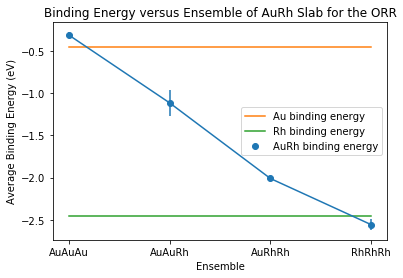

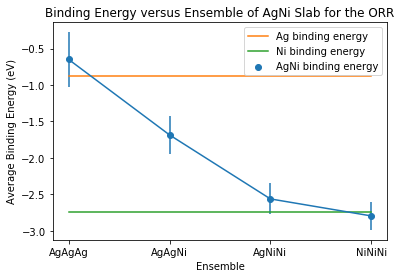

In [14]:
plot_BE_change_with_ensemble('Au','Rh','S','O',show_pure=True)
plot_BE_change_with_ensemble('Ag','Ni','S','O',show_pure=True)

<h4>HER</h4>
Below we plot how the ensemble effects the binding energy for a few pairing of a weak and strong binding metal to hydrogen.  Similar to the Oxygen binding energies, AuRh has a linear relationship betwen ensemble and average binding energy.  However, the AgPt alloy seems to be a bit different than all other cases we have seen.  We will keep this outlier in mind as we explore the data.  

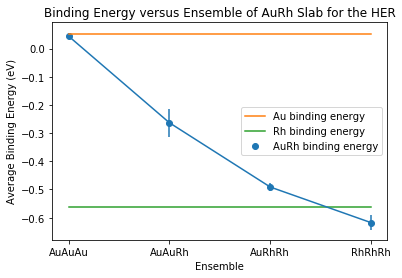

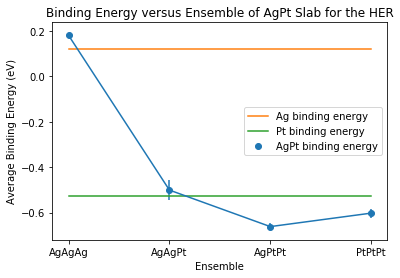

In [15]:
plot_BE_change_with_ensemble('Au','Rh','S','H',show_pure=True)
plot_BE_change_with_ensemble('Ag','Pt','S','H',show_pure=True)

<h3>How does the metal pairing effect binding energies for a fixed composition?</h3>

<h5> ORR AAA ensemble</h5>
Below I show how the AAA ensemble changes with various metal pairings.  Metals are sorted from the weakest to strongest binding metals to oxygen.  Note the black square indicates missing data.  The data below suggests that while alloying with another can effect binding energies, the primary effect is the ensemble.  This is why we see the columns of similar colors below.  

Note that the blue boxes below represent metals that are over binding, while the red represents underbinding.  The data for the slabs below confirms the data seen in Figure 1 where Au and Ag are under binding Oxygen while all other metals are over binding oxygen.  

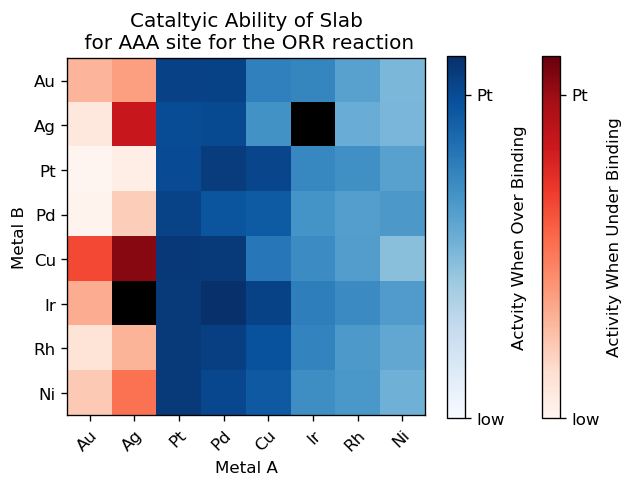

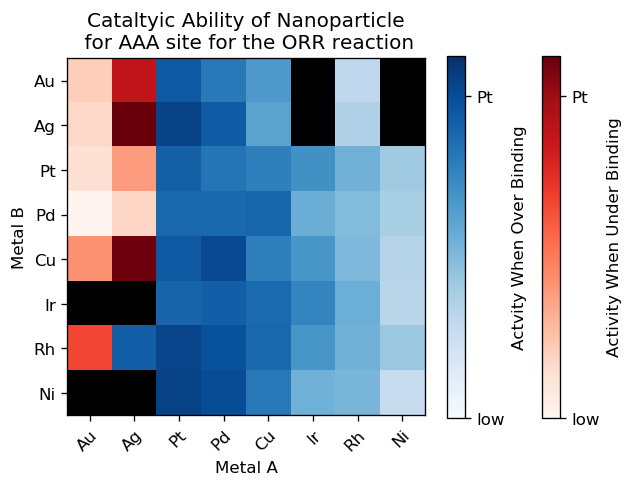

In [16]:
metals = ['Au','Ag','Pt','Pd','Cu','Ir','Rh','Ni'] # Metals sorted from weakest to strongest binding based on Figure 1
plot_catalytic_activity(metals,metals,'S','O','AAA')
plot_catalytic_activity(metals,metals,'N','O','AAA')

<h5>ORR AAB ensemble</h5>
Below I show how the AAB ensemble changes with various metal pairings.  Metals are sorted from the weakest to strongest binding metals to oxygen.  The data below suggests that pairing two weak binding metals will produce a weak binding metal, and vice versa.  It all suggests that alloying a strong and weak binding metal will produce and intermediate binding energy (as was shown previously in a few example cases). That is why we see the upper left hand corner (where we are alloying two weak binding metals) with a light red activity, the lower right hand corner with a light blue activity and intermediate values between.  

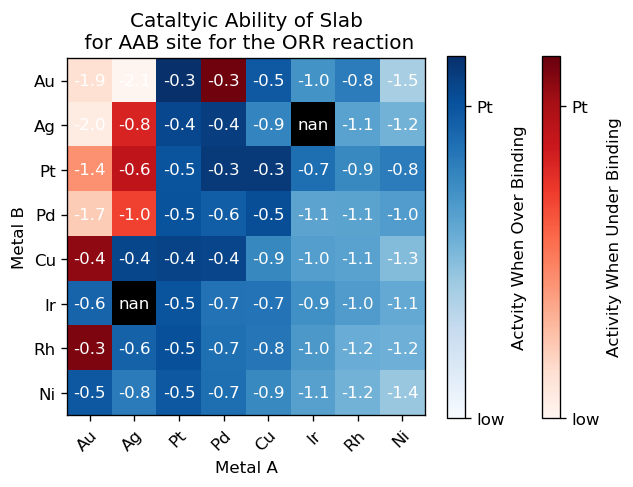

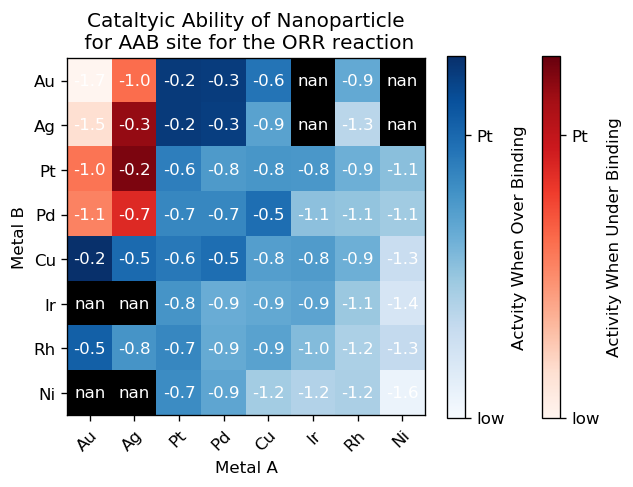

In [17]:
plot_catalytic_activity(metals,metals,'S','O','AAB',show_catalytic_activity=True)
plot_catalytic_activity(metals,metals,'N','O','AAB',show_catalytic_activity=True)

<h5> HER AAA ensemble</h5>
Below I show how the AAA ensemble changes with various metal pairings.  Metals are sorted from the weakest to strongest binding metals to oxygen.  Note the black square indicates missing data.  The data below suggests that while alloying with another can effect binding energies, the primary effect is the ensemble. These results are similar to the ORR plots shown previously.

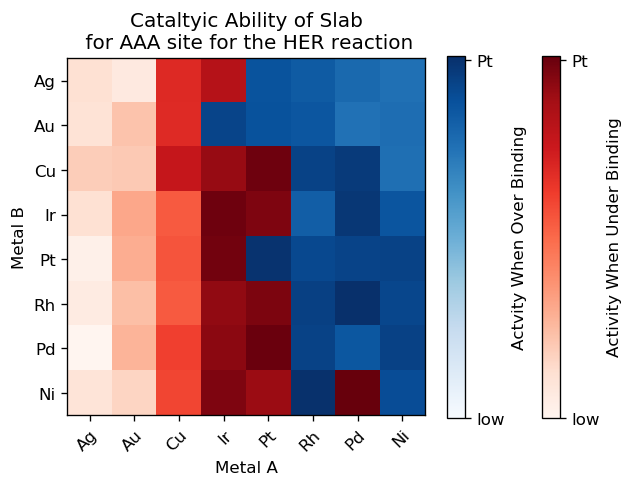

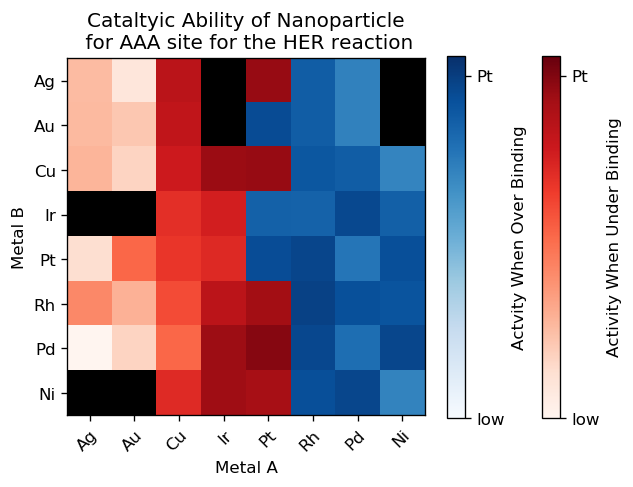

In [18]:
metals = ['Ag','Au','Cu','Ir','Pt','Rh','Pd','Ni']
plot_catalytic_activity(metals,metals,'S','H','AAA')
plot_catalytic_activity(metals,metals,'N','H','AAA')

<h5> HER AAB ensemble</h5>

The general trend here is very similar to what we saw with ORR where the upper hand corner is light red and the lower left hand corner is the lightest blue.  However the transition is from weak to strong binding energies is not as obvious as the ORR data.  This is something I will keep in mind along with the non-linear ensemble v binding energy found earlier as I continue to investigate this dataset.  

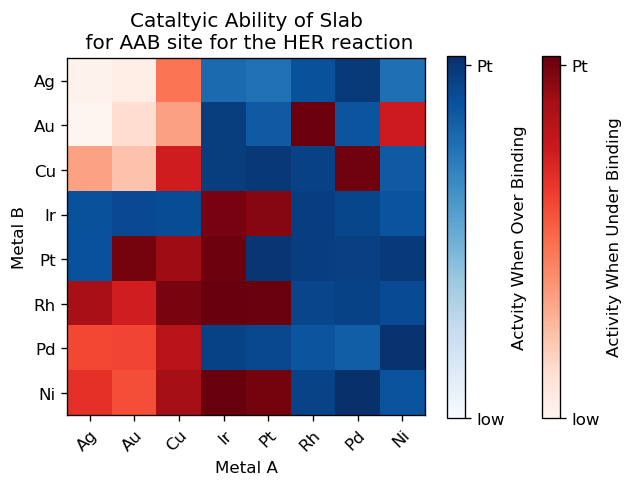

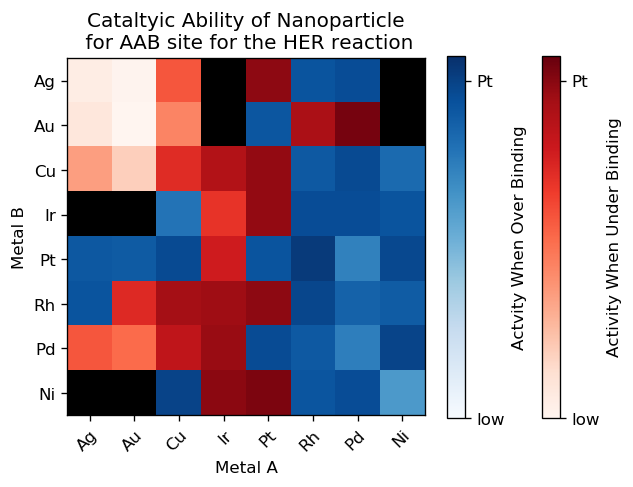

In [19]:
plot_catalytic_activity(metals,metals,'S','H','AAB')
plot_catalytic_activity(metals,metals,'N','H','AAB')

<h3>Have we found any materials better than Platinum?</h3>
One important questions we may have is have we identified any materials that have the potential to have higher catalytic activity than platinum.  Below we will list all materials that have higher catalytic actvity than Pt for the HER and the ORR reaction. 

<h5>ORR</h5>


In [20]:
# Get all Slab materials with higher catalytic activity than Pt
Proming_ORR = df[(df.Append == 'O') & 
                 (df.catalytic_ability > df.loc['S/Pt/None/Pt/None/O','catalytic_ability'])
                ].sort_values(by='catalytic_ability')
print('We found', len(Proming_ORR), 'slabs with high predicted catalytic ability than pure platinum.')  
print()
# Print the ten candidates with highest catalytic activity
print('The top ten candidates are:')
for i,index in enumerate(Proming_ORR.index.to_numpy()):  #.get_values()):
    print_material_from_key(index)
    if i > 8: 
        break

We found 45 slabs with high predicted catalytic ability than pure platinum.

The top ten candidates are:
Ni0Pd3 Nanoparticle for ORR
Pd1Pt2 Slab for ORR
Pd3Ag0 Slab for ORR
Cu0Pd3 Nanoparticle for ORR
Rh1Pt2 Slab for ORR
Ni0Pd3 Slab for ORR
Cu2Pd1 Slab for ORR
Rh1Au2 Nanoparticle for ORR
Cu3Pt0 Slab for ORR
Rh0Pt3 Nanoparticle for ORR


<h5>HER</h5>

In [21]:
Proming_ORR = df[(df.Append == 'H') & 
                 (df.catalytic_ability > df.loc['S/Pt/None/Pt/None/H','catalytic_ability'])
                ].sort_values(by='catalytic_ability')
print('We found', len(Proming_ORR), 'slabs with high predicted catalytic ability than pure platinum.')  
print()
# Print the ten candidates with highest catalytic activity
print('The top ten candidates are:')
for i,index in enumerate(Proming_ORR.index.to_numpy()):
    print_material_from_key(index)
    if i > 8: 
        break

We found 15 slabs with high predicted catalytic ability than pure platinum.

The top ten candidates are:
Pd0Pt3 Slab for HER
Cu1Pd2 Slab for HER
Ni0Rh3 Slab for HER
Ir2Pt1 Slab for HER
Ni2Pd1 Slab for HER
Ni0Pd3 Slab for HER
Rh0Pd3 Slab for HER
Rh2Au1 Slab for HER
Ni1Pd2 Slab for HER
Ni1Pt2 Nanoparticle for HER


<h3>Can we predict the binding energy based on the ensemble?</h3>

This question would have broad impacts to smartly designing materials.  Thinking back to the ensemble versus binding energy plots, most examples seemed to have a linear relationship starting at the AAA site where the binding energy is close to a pure metal A material and transitioning to the BBB site where the binding energy was close to the pure metal B material. The linear trend suggests that the intermetiate binding energies (AAB/ABB) could just be a weighted binding energy of the two metals as follows:

$BE_{\text{predicted}} = N_A * BE_A + N_B * BE_B$

where $BE_A$ is the binding energy a pure metal A material, $BE_B$ is the binding energy a pure metal B material, $N_A$ is the number of metal A atoms at the ensemble, $N_B$ is the number of metal B atoms at the ensemble, and $BE_{\text{predicted}}$ is the predicted binding energy.

Below I will compare this scheme with the actual binding energies and see how accurately it predicts the binding energies of materials in our database. 

In these plots below I will highlight datapoints with large "distance moved".  In all calculations we place O or H in the center of a three atom hollow site.  The "distance moved" was calculated as one metric to detect if the adsorbate moved significantly from the hollow site.  I plot this since I am suspicious that it may play a role in accurately predicting binding energies

##### ORR

The root mean squared error of the weighted average scheme is  0.23778547595732738 eV


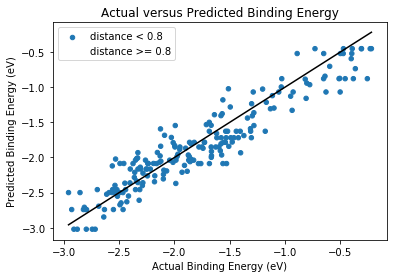

In [22]:
rmse_orr_weighted_average = plot_predicted_v_actual_BE('O',color_sites=0.8)
print('The root mean squared error of the weighted average scheme is ', rmse_orr_weighted_average, 'eV')

##### HER

The root mean squared error of the weighted average scheme is  0.12160999354972975 eV


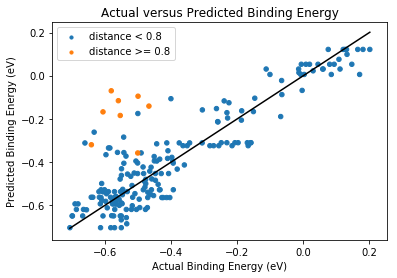

In [23]:
rms_her_weighted_average = plot_predicted_v_actual_BE('H',color_sites=0.8)
print('The root mean squared error of the weighted average scheme is ', rms_her_weighted_average, 'eV')
#figuring out how to color datapoints via masking -- debugging these functions which are currently being updated


A few comments on data above.  First of all, this prediction for ORR looks great! It is clearly doing a pretty good job of predicting catalytic ability.  Even though the RMSE is lower for HER because of the energy range of binding energies, the model seems to perform not as well.  Specifically, we can see that there are several data points with large distances moved that are outliers in the plots above.   

<h2 id="ML"> Machine Learning: Building a Regression Model <h2>

<h3>Can we do better than the weighted average by using machine learning?</h3> 

The above scheme for predicting catalytic activity does a pretty good job especially for ORR! However, one question is could we do better by using more advanced statistical methdos and machine learning techniques.  

<h4>Standard Linear Regression</h4> 

Below I define features that make sense to use and perform standard linear regression

<h5>ORR</h5> 

The root mean squared error using kernel ridge regression is  0.41739801531029114 eV


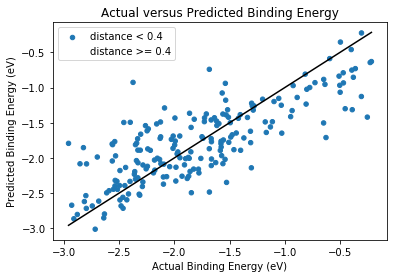

In [45]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('O',features,add_weighted_be=False)
#reg, test_x,test_y = train_with_scikits(X_all,y_all,linear_model.LinearRegression())
predicted = cross_val_predict(linear_model.LinearRegression(), X_all, y_all, cv=10)
rmse_orr_lin_reg = plot_predicted_v_actual_BE('O',ML=None,test_x=y_all,test_y=predicted)
print('The root mean squared error using kernel ridge regression is ', rmse_orr_lin_reg , 'eV')

<h5>HER</h5> 

The root mean squared error using kernel ridge regression is  0.16371436779428206 eV


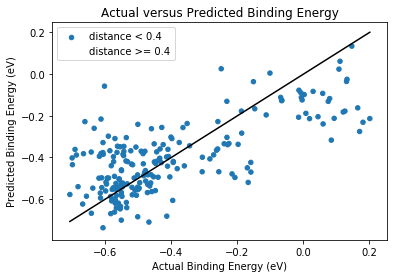

In [46]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('H',features,add_weighted_be=False)
#reg, test_x,test_y = train_with_scikits(X_all,y_all,linear_model.LinearRegression())
predicted = cross_val_predict(linear_model.LinearRegression(), X_all, y_all, cv=10)
rmse_her_lin_reg = plot_predicted_v_actual_BE('H',ML=None,test_x=y_all,test_y=predicted)
print('The root mean squared error using kernel ridge regression is ', rmse_her_lin_reg, 'eV')

<h4> Try having weighted average of binding energy be a feature </h4>

The above case performs much worse! It is clear, that the weighted pure binding energies ($N_A * BE_A$ and $N_B * BE_B$)are needed as a feature for a linear model.  Next, I will do one more linear regression where I use the weighted BE. 

<h4> ORR </h4>

The root mean squared error using kernel ridge regression is  0.20236418857459504 eV


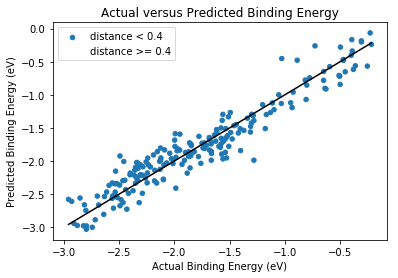

In [47]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('O',features,add_weighted_be=True)
#reg, test_x,test_y = train_with_scikits(X_all,y_all,linear_model.LinearRegression())
#print(reg)
predicted = cross_val_predict(linear_model.LinearRegression(), X_all, y_all, cv=10)
#rmse_orr_lin_reg_add_weighted = plot_predicted_v_actual_BE('O',ML=reg,test_x=test_x,test_y=test_y)
rmse_orr_lin_reg_add_weighted = plot_predicted_v_actual_BE('O',ML=None,test_x=y_all,test_y=predicted)
print('The root mean squared error using kernel ridge regression is ', rmse_orr_lin_reg_add_weighted, 'eV')
# check to make sure that this is coloring based on distance -- probably is not -- need to mask in in get_all_training_data

<h5>HER</h5>

The root mean squared error using kernel ridge regression is  0.08126509416843139 eV


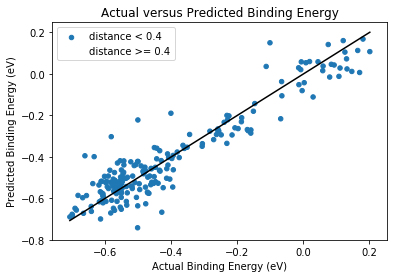

In [48]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('H',features,add_weighted_be=True)
#reg, test_x,test_y = train_with_scikits(X_all,y_all,linear_model.LinearRegression())
#rmse_her_lin_reg_add_weighted = plot_predicted_v_actual_BE('H',ML=reg,test_x=test_x,test_y=test_y)
predicted = cross_val_predict(linear_model.LinearRegression(), X_all, y_all, cv=10)
rmse_her_lin_reg_add_weighted = plot_predicted_v_actual_BE('H',ML=None,test_x=y_all,test_y=predicted)
print('The root mean squared error using kernel ridge regression is ', rmse_her_lin_reg_add_weighted , 'eV')


We went from an RMSE of 0.238 eV and 0.121 eV for ORR and HER respectively for the weighted binding energy heuristic to an RMSE of 0.202 eV and 0.081 ev for ORR and HER respectivley with mulitple linear regression. Next, let's explore if there are any other features other than the weighted pure binding energies ($N_A * BE_A$ and $N_B * BE_B$) that effect our repression model.

<h4> Ridge Regression to determine most important features </h4>

In the first cell below I will confirm that ridge regression can model our data. 

In the next two cells I will vary the value of alpha in ridge regression and see how the coefficients on various features change.  This will give insight into the features that are most important for predicting binding energy.

The root mean squared error using kernel ridge regression is  0.07483569584627457 eV


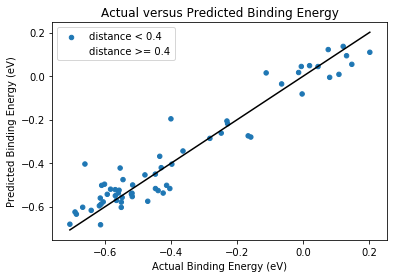

In [49]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('H',features,add_weighted_be=True)
min_max_scaler = preprocessing.MinMaxScaler()
X_all_scaled = min_max_scaler.fit_transform(X_all)
reg, test_x,test_y = train_with_scikits(X_all_scaled,y_all,linear_model.Ridge(alpha= 0.5))   #KernelRidge(alpha=0.5))
print('The root mean squared error using kernel ridge regression is ', plot_predicted_v_actual_BE('H',ML=reg,test_x=test_x,test_y=test_y), 'eV')

<h5>HER</h5>

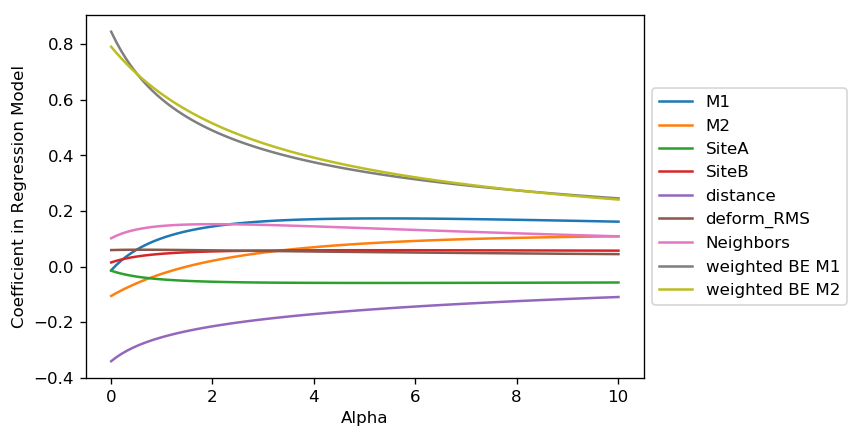

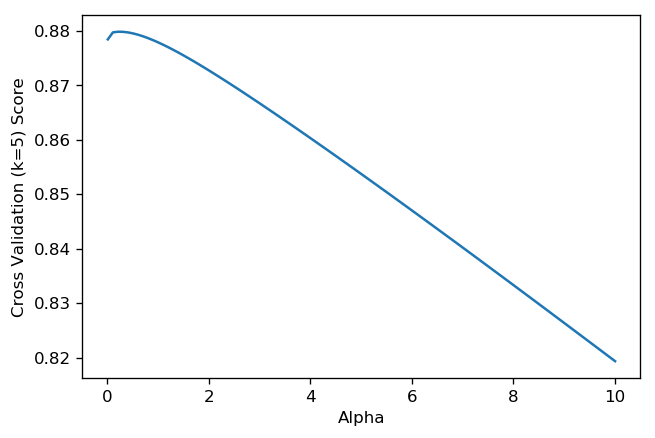

In [50]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('H',features,add_weighted_be=True)
features.append('weighted BE M1')
features.append('weighted BE M2')
plot_ridge_coefficients_performance_on_scaled_data(X_all, y_all,features)

<h5>ORR</h5>

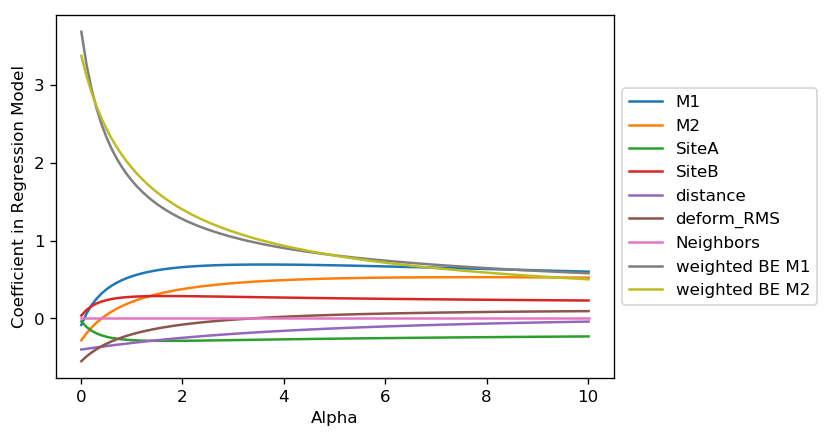

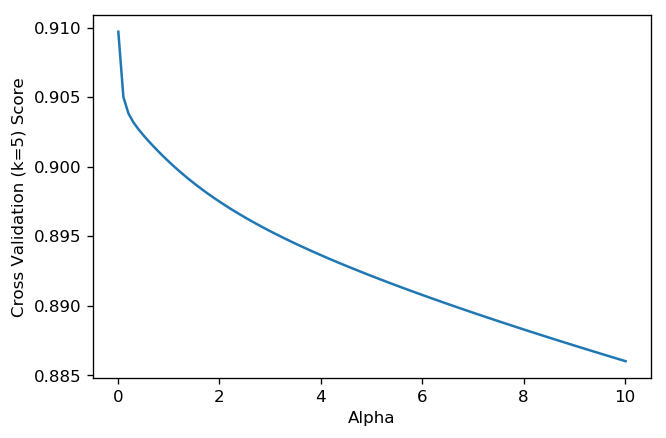

In [52]:
features = ['M1','M2','SiteA','SiteB','distance','deform_RMS','Neighbors']
X_all,y_all = get_all_training_data('O',features,add_weighted_be=True)
features.append('weighted BE M1')
features.append('weighted BE M2')
plot_ridge_coefficients_performance_on_scaled_data(X_all, y_all,features)

Data Above is helpful for feature selection, at least for a linear model.  This suggests that the weighted pure binding energies ($N_A * BE_A$ and $N_B * BE_B$) are the most important features. Interstingly, it also suggest that distance plays a critical role in HER, but does not play as large of role in ORR.  It is also note worth that while there are positive weights for the weighted pure binding energies, there is a negative weight on the distance moved.  This suggests that the more H moves from the original hollow site, the stronger the binding energy gets. Perhaps this means that in cases of large distance moved a significant geometry change occured possibly to a new atomic environment leading to stronger binding energies. 

First we will plot how frequently and at what distances O and H moved in the optimization.  Below are two histograms of distance moved for ORR and HER respectively: 

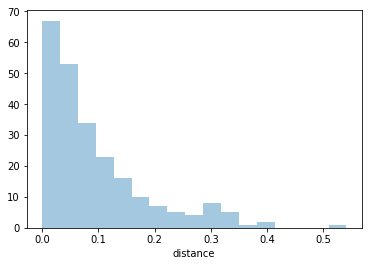

In [36]:
sb.distplot(df[(df.Append == 'O')]['distance'],kde = False)
 # can we change text size easily 

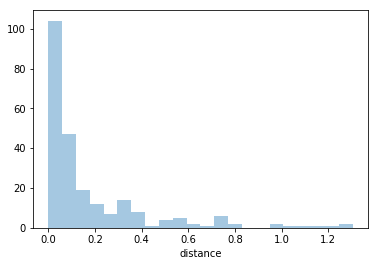

In [37]:
sb.distplot(df[(df.Append == 'H')]['distance'],kde = False)

We see from the histograms of frequency of larger distance is rare, but is happening in the HER case.  This also fits with the results we found earlier where only a few materials had moved large distances but those materials did not perform as well with the weighted pure binding energy heuristic. 

Let's also dig into the case we found earlier where the ensemble versus binding energies was not linear for the HER: 

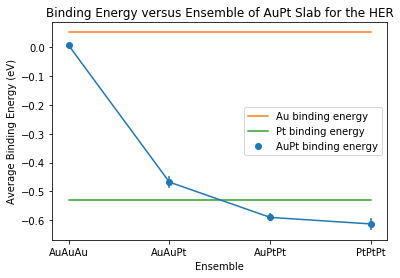

In [55]:
plot_BE_change_with_ensemble('Au','Pt','S','H',show_pure=True)

In [56]:
print( 'The number of neighbors for each ensemble in the AgPt Slab alloy:')
print('AAA:',df.loc[get_keys_for_material('Ag','Pt','S','H','AAA'),'Neighbors'])
print('AAB:',df.loc[get_keys_for_material('Ag','Pt','S','H','AAB'),'Neighbors'])
print('AAB:',df.loc[get_keys_for_material('Pt','Ag','S','H','AAB'),'Neighbors'])
print('AAA:',df.loc[get_keys_for_material('Pt','Ag','S','H','AAA'),'Neighbors'])

The number of neighbors for each ensemble in the AgPt Slab alloy:
AAA: 3
AAB: 1
AAB: 2
AAA: 3


In [58]:
print( 'The types of neighbors for each ensemble in the AgPt Slab alloy:')
print('AAA:',df.loc[get_keys_for_material('Ag','Pt','S','H','AAA'),'neighbor_identity'])
print('AAB:',df.loc[get_keys_for_material('Ag','Pt','S','H','AAB'),'neighbor_identity'])
print('AAB:',df.loc[get_keys_for_material('Pt','Ag','S','H','AAB'),'neighbor_identity'])
print('AAA:',df.loc[get_keys_for_material('Pt','Ag','S','H','AAA'),'neighbor_identity'])

The types of neighbors for each ensemble in the AgPt Slab alloy:
AAA: [['Ag', 'Ag', 'Ag'], ['Ag', 'Ag', 'Ag'], ['Ag', 'Ag', 'Ag'], ['Ag', 'Ag', 'Ag'], ['Ag', 'Ag', 'Ag']]
AAB: [['Pt'], ['Pt'], ['Pt'], ['Pt'], ['Pt', 'Pt']]
AAB: [['Pt', 'Pt'], ['Pt', 'Pt'], ['Pt', 'Pt'], ['Pt', 'Pt'], ['Pt', 'Pt', 'Pt']]
AAA: [['Pt', 'Pt', 'Pt'], ['Pt', 'Pt'], ['Pt', 'Pt', 'Pt'], ['Pt', 'Pt', 'Pt'], ['Pt', 'Pt', 'Pt']]


Above, shows atleast for this example, that my prediction was correct!  In this AAA and AAB sites are where they should be, surrounded by all Ag or Pt.  However, when we consider the AgPt case we see that Hydrogen move to an environment where it was surrounded by Pt.  

Above also suggest that there is either an error in determining neighbors in our back end possibly with the thresholds used to determine neighbors or with the calculations itself since there is a Pt3 site at the AgAgPt site.  Next, I will check for these issues in our data and consider adding in the binding energies of pure metals and the top and bridge sites where O or H is sorrounded by 1 or 2 atoms instead of three.  These values could be important for predicting catalytic ability where O or H moves to top or bridge sites.  